## 1. Import Libraries

In [44]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import plotly.express as px
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.cluster import DBSCAN


## 2. Data Exploration

In [45]:
data=pd.read_csv('customers.csv')
data.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [46]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
CustomerID,200.0,100.50,57.879185,1.0,50.75,100.5,150.25,200.0
Age,200.0,38.85,13.969007,18.0,28.75,36.0,49.00,70.0
Annual Income (k$),200.0,60.56,26.264721,15.0,41.50,61.5,78.00,137.0
Spending Score (1-100),200.0,50.20,25.823522,1.0,34.75,50.0,73.00,99.0


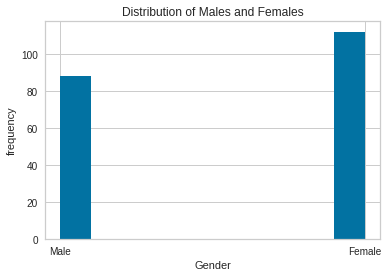

In [47]:
plt.hist(data['Gender'])
plt.xlabel('Gender')
plt.ylabel('frequency')
plt.title('Distribution of Males and Females')
plt.show()

There are slightly more women than men in this dataset.

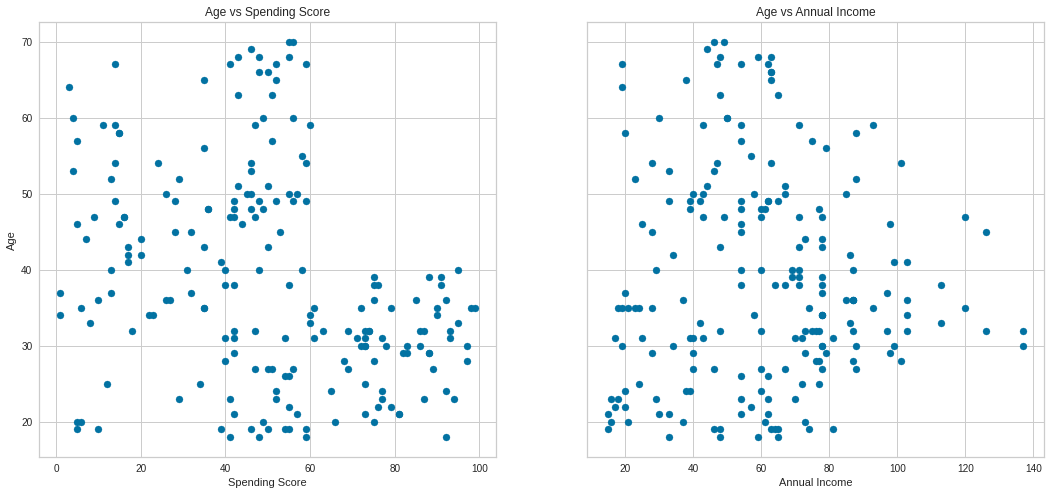

In [48]:
fig,axs=plt.subplots(1,2,sharey=True,figsize=(18,8))
axs[0].scatter(x=data['Spending Score (1-100)'],y=data['Age'])
axs[0].set_title('Age vs Spending Score')
axs[0].set_xlabel('Spending Score')
axs[0].set_ylabel('Age')
axs[1].scatter(x=data['Annual Income (k$)'],y=data['Age'])
axs[1].set_title('Age vs Annual Income')
axs[1].set_xlabel('Annual Income')



plt.show()

There is really no linear relationship between age and spending score or annual income.

In [49]:
data['Gender']=pd.get_dummies(data['Gender'])
data.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,0,19,15,39
1,2,0,21,15,81
2,3,1,20,16,6
3,4,1,23,16,77
4,5,1,31,17,40


# 3. Cluster Analysis

In [50]:
X=data.drop(['CustomerID'],axis=1)
X.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,0,19,15,39
1,0,21,15,81
2,1,20,16,6
3,1,23,16,77
4,1,31,17,40


We scale the data to bring all the values to the same scale. 

This step is very important. Without it, we would have very large within-cluster sum of squares (WCSS).


In [51]:
data_scaled = pd.DataFrame(MinMaxScaler().fit_transform(X),
                          columns=X.columns)
data_scaled.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,0.0,0.019231,0.000000,0.387755
1,0.0,0.057692,0.000000,0.816327
2,1.0,0.038462,0.008197,0.051020
3,1.0,0.096154,0.008197,0.775510
4,1.0,0.250000,0.016393,0.397959


When the dimension of the data is large, we may want to reduce the dimension of the data. Principal Component Analysis (PCA) is commonly used. This dataset is small. We may deicide not to apply Principal Component Analysis (PCA), however, we'd use it.

## 3. 1 PCA Variance Explained

In [52]:
def pca_variance_table(data_scaled):
    pca = PCA().fit(data_scaled)
    variance=pca.explained_variance_ratio_*100
    cumulative_sum=variance.cumsum()
    pca_variance=pd.DataFrame({'variance(%)':variance,
                                'cumulative_sum':cumulative_sum})
    return pca_variance

In [53]:
#We want to take the components whose  cumulative sum would result to a high variance. 
#Hence, we calculate the cumulative sum.
pca_variance=pca_variance_table(data_scaled)
pca_variance

,variance(%),cumulative_sum
0,57.076896,57.076896
1,21.404941,78.481838
2,10.928099,89.409936
3,10.590064,100.000000


> We see that two components have explained up to 78% of the data. Hence, we can use the just 2 principal components.

> Hence, we can go ahead to consider two components for our PCA.


In [54]:
def principal_factors(data,n_components):
    pca = PCA(n_components=n_components).fit(data)
    column=['PF'+str(i) for i in range(pca.n_components)]
    data_new= pd.DataFrame(pca.transform(data),columns=column)
    return data_new

In [55]:
data_new=principal_factors(data=data_scaled,n_components=2)
data_new.head()

,PF0,PF1
0,0.532955,-0.227841
1,0.513939,-0.493080
2,-0.446266,0.087079
3,-0.478796,-0.366617
4,-0.451984,0.003006


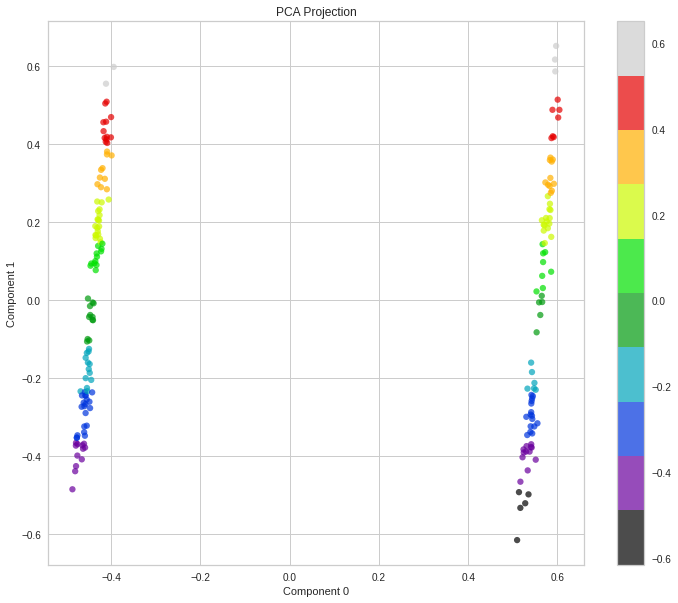

In [56]:
plt.figure(figsize=(12,10))
plt.scatter(data_new['PF0'],data_new['PF1'], c=data_new['PF1'],
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.xlabel('Component 0')
plt.ylabel('Component 1')
plt.title('PCA Projection')
plt.show()

## 3. 2 K-Means

We first use the elbow method to determine the number of clusters

### 3.2.1 Elbow Method

In [57]:
wcss = []
for i in range(1, 10): #The data set is small. So, we consider the range of 1 - 10 clusters.
    kmeans = KMeans(n_clusters = i, init='k-means++',random_state=1)
    # Fit the data points 
    kmeans.fit(data_scaled.values)
    # Get the WCSS (inertia) value
    wcss.append(kmeans.inertia_)

fig = px.line(wcss, 
              title="WCSS by Clusters")
fig.update_traces(mode="markers+lines")
fig.update_layout(
    xaxis_title="Clusters",
    yaxis_title="inertia",
    font=dict(
        family="Courier New, monospace",
        size=15,
        color="RebeccaPurple"
    )
)

fig.show()

From the above, we see that the optimal number of clusters by the elbow method is 3. We can further verify by investigating the silhouette score of some clusters.

For n_clusters = 2 The average silhouette_score is : 0.6774021509986292
For n_clusters = 3 The average silhouette_score is : 0.6880209278355843
For n_clusters = 4 The average silhouette_score is : 0.6851605920014778
For n_clusters = 5 The average silhouette_score is : 0.6553657860935921
For n_clusters = 6 The average silhouette_score is : 0.6171629643475078
For n_clusters = 7 The average silhouette_score is : 0.6051928502215642


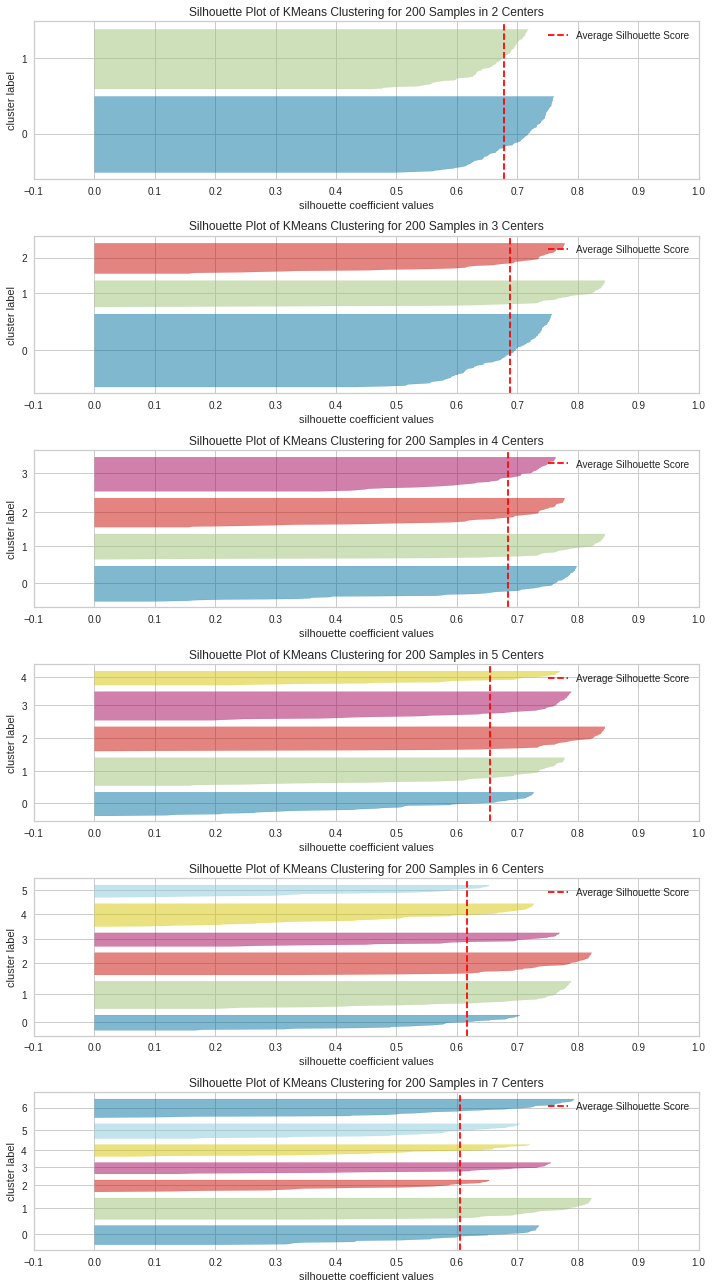

In [58]:

k_range = range(2, 8)
fig, axes = plt.subplots(6, 1, figsize=(10, 18))

for i in k_range:   
    model = KMeans(i, init='k-means++', n_init=1000, random_state=1)
    cluster_labels = model.fit_predict(data_new)
    
    silhouette_avg = metrics.silhouette_score(data_new, cluster_labels)
    print(
        "For n_clusters =",i,"The average silhouette_score is :",silhouette_avg)
    visualizer = SilhouetteVisualizer(model, colors='yellowbrick', ax=axes[i-2])
    visualizer.fit(data_new)
    visualizer.finalize()
    axes[i-2].set_xlim(-0.1, 1)
    
plt.tight_layout()

The thickness from a Sihoutte plot tells us how populated a particular cluster is. The thicker the plot, the more points there are in that cluster.

The line from the Sihoutte plot tells the average silhouette scores of all the clusters in a single plot.

3 or 4 clusters is optimal since each point is above the average silhouette score. But we take 4 since the thickness is even in each cluster.

In [59]:
model = KMeans(n_clusters=4, init='k-means++', n_init=100, max_iter=1000,random_state=1)
# Fit to the data and predict the cluster assignments for each data point
km_clusters = model.fit_predict(data_new.values)
# View the cluster assignments


In [60]:
column=['Class']
data["Class"]=pd.DataFrame(km_clusters)
data.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),Class
0,1,0,19,15,39,1
1,2,0,21,15,81,1
2,3,1,20,16,6,3
3,4,1,23,16,77,0
4,5,1,31,17,40,0


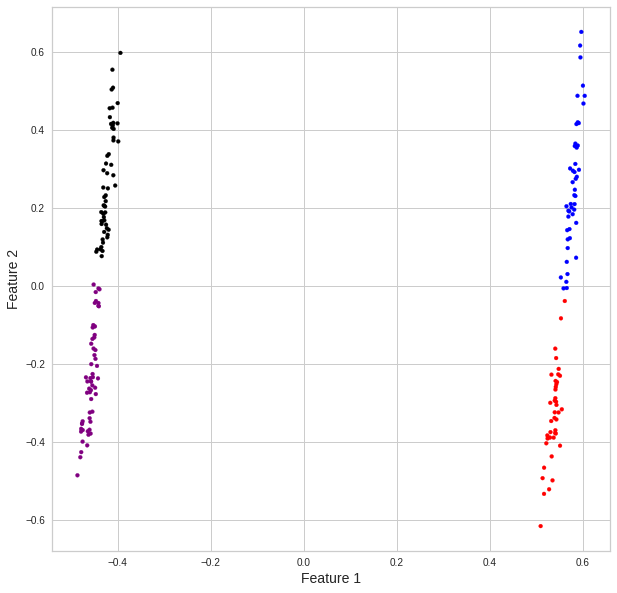

In [61]:
import matplotlib

# Plotting resulting clusters
colors=['purple','red','blue','black']
plt.figure(figsize=(10,10))
plt.scatter(data_new['PF0'],data_new['PF1'],c=data['Class'],
            cmap=matplotlib.colors.ListedColormap(colors),s=15)
plt.xlabel('Feature 1',fontsize=14)
plt.ylabel('Feature 2',fontsize=14)
plt.savefig('kmeans.png')
plt.show()


## 3.2.3 K-means Evaluation

When using Calinski Harabasz Score, the higher the value, the better the clusters.

In [62]:
labels = model.labels_
metrics.calinski_harabasz_score(data_new, labels)

1109.4857362684977

The Silhoutte Score is between -1 and 1 where +1 indicates highly dense clustering. This metric is good since it gives us a bound of our clustering algorithm, unlike the CH score where we cannot really say how good it is except we measure it in relation to another algorithm.

In [63]:
metrics.silhouette_score(data_new, labels, metric='euclidean')


0.6851605920014778

## 3.3 DBScan

In [64]:
min_samples=data_new.shape[1]
db = DBSCAN(eps=0.10, min_samples=min_samples*2)
db.fit(data_new)

DBSCAN(eps=0.1, min_samples=4)

In [65]:
#Let's see the cluster assignments
y_pred = db.fit_predict(data_new[['PF0', 'PF1']])
set(list(y_pred))

{0, 1}

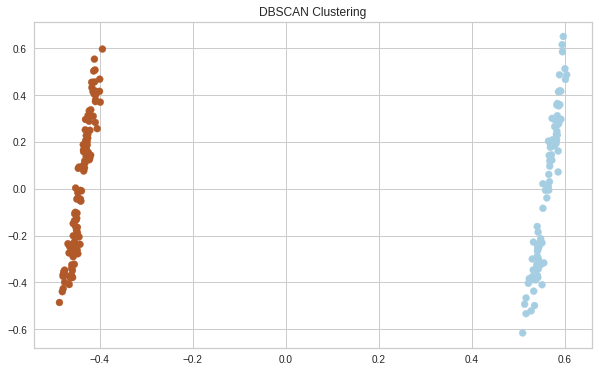

In [66]:
plt.figure(figsize=(10,6))
plt.scatter(data_new['PF0'],data_new['PF1'],c=y_pred, cmap='Paired')
plt.title("DBSCAN Clustering")
plt.savefig('DBSCAN.png')
plt.show()

### 3.3.1 DBScans Evaluation

In [67]:
db_labels = db.labels_
metrics.calinski_harabasz_score(data_scaled, db_labels)

262.4745661327262

In [68]:
metrics.silhouette_score(data_scaled, db_labels, metric='euclidean')


0.5194624832665107

From the above, we see that it is difficult to say what epsilon and the number of min samples should be. We can try to carry out an unsupervised method of clustering to get distances first to get our epsilon.

### 3.3.2 Searching through a range of values to find optimal epsilon


In [69]:
preds={}
for values in np.arange(0.8,1.6,0.01):
    db = DBSCAN(eps=values, min_samples=data_new.shape[1]*2)
    db.fit(data_new)
    y_pred = set(list(db.fit_predict(data_new)))
    preds[values]=y_pred
pd.DataFrame(preds.items(),columns=['epsilon','cluster'])

,epsilon,cluster
0,0.80,"{0, 1}"
1,0.81,"{0, 1}"
2,0.82,"{0, 1}"
3,0.83,"{0, 1}"
4,0.84,"{0, 1}"
5,0.85,"{0, 1}"
6,0.86,"{0, 1}"
7,0.87,"{0, 1}"
8,0.88,"{0, 1}"
9,0.89,"{0, 1}"


In [70]:
pd.set_option('display.max_rows',None)
table_pred=pd.DataFrame(preds.items(),columns=['epsilon','cluster'])
table_pred

,epsilon,cluster
0,0.80,"{0, 1}"
1,0.81,"{0, 1}"
2,0.82,"{0, 1}"
3,0.83,"{0, 1}"
4,0.84,"{0, 1}"
5,0.85,"{0, 1}"
6,0.86,"{0, 1}"
7,0.87,"{0, 1}"
8,0.88,"{0, 1}"
9,0.89,"{0, 1}"


# 6. Hierarchial Clustering: Agglomerative Clustering

In [71]:
import scipy.cluster.hierarchy as shc

Here, we use the scaled data and see the divisions of the clustering algorithm while applying ward's method.

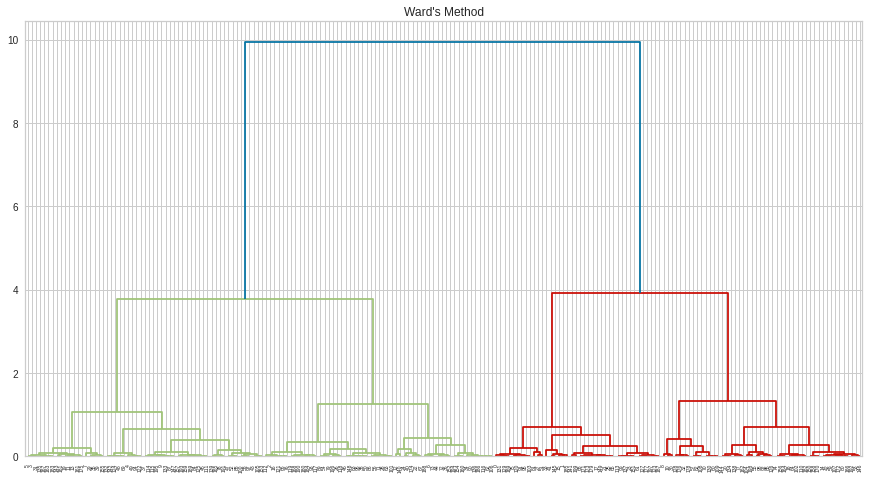

In [72]:
plt.figure(figsize=(15, 8))  
plt.title("Ward's Method")  
dend = shc.dendrogram(shc.linkage(data_new, method='ward'))
plt.axhline(y=60, color='r', linestyle='--')
plt.show()

When we make a cut at 2, we have 4 clusters. We then apply this to the agglomerative algorithm.

In [73]:
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')  
agg_clusters=cluster.fit_predict(data_new)

In [74]:
data_new['Class']=agg_clusters

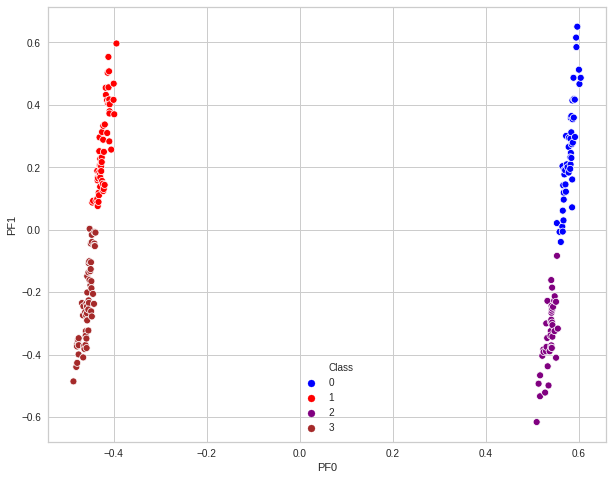

In [75]:
import seaborn as sns
plt.figure(figsize=(10,8))
graph=sns.scatterplot(data_new["PF0"],
                data_new["PF1"],hue=data_new['Class'],
                palette=['blue','red','purple','brown'])
plt.savefig('agglomerative.png')

plt.show()

We see that the above result is almost exactly the same as that of K-Means.

In [76]:
agg_labels=list(agg_clusters)
metrics.silhouette_score(data_new, agg_labels, metric='euclidean')


0.8898794875857756

We see that indeed this method provides a better silhouette score so is thus the best method here.

# 5. Saving the K-Means Model

In [ ]:
import pickle
pickle.dump(model, open('model.pkl','wb'))

In [ ]:
model = pickle.load(open('model.pkl','rb'))
print(model.predict([[2.6, 8]]))

# 4. Conclusion

From the above, we see that the agglomerative clustering  gave clusters with better inertia. We see that there are four categories of customers. Next, we study the characteristics of the customers.